Adapted from [MultivariateStats.jl](https://juliastats.org/MultivariateStats.jl/stable/pca/).

In [46]:
using MultivariateStats, RDatasets, Plots

In [47]:
# load iris dataset
iris = dataset("datasets", "iris")

# split half to training set
Xtr = Matrix(iris[1:2:end,1:4])'
Xtr_labels = Vector(iris[1:2:end,5])

# split other half to testing set
Xte = Matrix(iris[2:2:end,1:4])'
Xte_labels = Vector(iris[2:2:end,5]);

# MultivariateStats.jl

## PCA

In [48]:
M = fit(PCA, Xtr; maxoutdim=3)

PCA(indim = 4, outdim = 3, principalratio = 0.9957325846529407)

In [49]:
Yte = predict(M, Xte)

3×75 Matrix{Float64}:
  2.72714    2.75491     2.32396   …  -1.92047   -1.74161   -1.37706
 -0.230916  -0.406149    0.646374      0.246554   0.127625  -0.280295
  0.253119   0.0271266  -0.230469     -0.180044  -0.123165  -0.314992

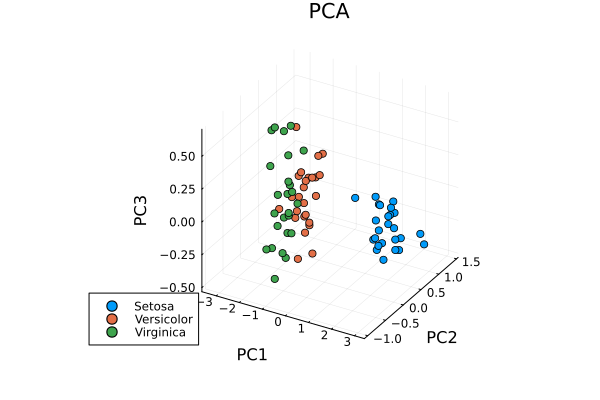

In [50]:
setosa_Y = Yte[:, Xte_labels .== "setosa"]
versicolor_Y = Yte[:, Xte_labels .== "versicolor"]
virginica_Y = Yte[:, Xte_labels .== "virginica"]

p1 = scatter(setosa_Y[1, :], setosa_Y[2, :], setosa_Y[3, :], marker=:circle, linewidth=0, label="Setosa")
scatter!(versicolor_Y[1, :], versicolor_Y[2, :], versicolor_Y[3, :], marker=:circle, linewidth=0, label="Versicolor")
scatter!(virginica_Y[1, :], virginica_Y[2, :], virginica_Y[3, :], marker=:circle, linewidth=0, label="Virginica")
plot!(p1, xlabel="PC1", ylabel="PC2", zlabel="PC3", title="PCA")

# ExpFamilyPCA

## PoissonEPCA

In [51]:
using Revise
using ExpFamilyPCA

Observe that even with printing, `PoissonEPCA` is nearly four times faster than `PCA` in `MultivariateStats.jl`.

In [52]:
poisson = PoissonEPCA()
A = fit!(poisson, Xte'; maxoutdim=3, verbose=true, maxiter=10, print_steps=1)'

Iteration: 1/10 | Loss: 47.627649731198964
Iteration: 2/10 | Loss: 6.9012487940263
Iteration: 3/10 | Loss: 5.528113523666417
Iteration: 4/10 | Loss: 5.395062132393681
Iteration: 5/10 | Loss: 5.381645587966238
Iteration: 6/10 | Loss: 5.37365255550967
Iteration: 7/10 | Loss: 5.3726694726216015
Iteration: 8/10 | Loss: 5.3724487356859365
Iteration: 9/10 | Loss: 5.372241186769003
Iteration: 10/10 | Loss: 5.372239912913614


3×75 adjoint(::Matrix{Float64}) with eltype Float64:
 0.919451  0.925526  0.943402  0.929365  …  1.03816   1.03013  1.02296
 1.01806   1.01314   1.02258   1.02615      0.996098  1.00397  0.983544
 1.00494   1.00264   1.0011    1.00157      1.00452   1.01039  1.02652

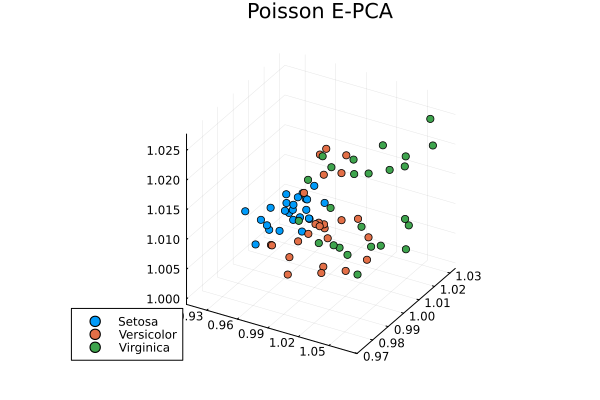

In [53]:
setosa_A = A[:, Xte_labels .== "setosa"]
versicolor_A = A[:, Xte_labels .== "versicolor"]
virginica_A = A[:, Xte_labels .== "virginica"]

p2 = scatter(setosa_A[1, :], setosa_A[2, :], setosa_A[3, :], marker=:circle, linewidth=0, label="Setosa")
scatter!(versicolor_A[1, :], versicolor_A[2, :], versicolor_A[3, :], marker=:circle, linewidth=0, label="Versicolor")
scatter!(virginica_A[1, :], virginica_A[2, :], virginica_A[3, :], marker=:circle, linewidth=0, label="Virginica")
plot!(p2, title="Poisson E-PCA")

PCA better clusters the low-dimensional data. Poisson E-PCA is best at compressing integer data and probabilities, so it makes sense that the low-dimensional representation of the data appears garbled. 

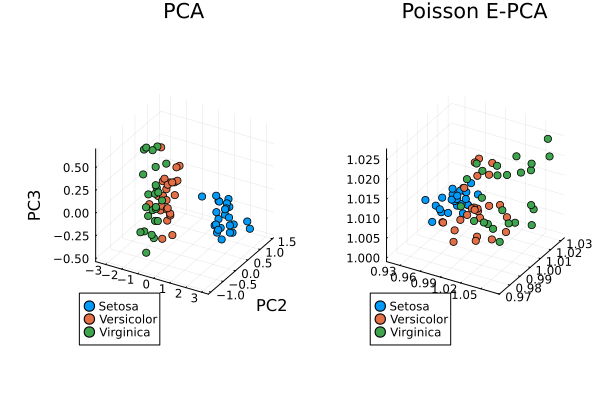

In [54]:
plot(p1, p2, layout=(1, 2))

Now, let's see how PCA and Poisson E-PCA fair on reconstruction.

In [55]:
Xr_PCA = reconstruct(M, Yte)

4×75 Matrix{Float64}:
 4.86449  4.61087   5.40782   5.00775   …  6.79346  6.58825  6.46774  5.94384
 3.04262  3.08695   3.89061   3.39069      3.20785  3.13416  3.03873  2.94737
 1.46099  1.48132   1.68656   1.48668      5.91124  5.39197  5.25542  5.02469
 0.10362  0.229519  0.421233  0.221041     2.28224  1.99665  1.91243  1.91901

In [56]:
Xr_poisson = decompress(Poisson, A')'

4×75 adjoint(::Matrix{Float64}) with eltype Float64:
 4.68611   4.78232   5.27016   …  6.66452  6.90462  6.66109  5.73524
 3.17492   3.13578   3.34481      2.76292  2.99581  3.02788  2.52038
 1.47002   1.63222   1.87615      6.71471  6.16294  5.2734   5.28213
 0.286065  0.334989  0.395878     2.60558  2.26161  1.78959  1.93149

Both, reconstruct the data nearly instantly.

## Implicit Poisson

One of the main features of ExpFamilyPCA.jl is the ability to induce a custom E-PCA objective from a user-provided convex function $G$. For example, to induce the Poisson E-PCA objective, we set $G = \exp(x)$. While this method is convenient for experimenting with different $G$ and link functinos, it is often slower than an explicit model that defines the Bregman divergence.

In [60]:
implicit_poisson = EPCA(x->exp(x))

ImplicitEPCA(missing, var"#15#16"(), ExpFamilyPCA.g, ExpFamilyPCA.Fg, ExpFamilyPCA.fg)

In [61]:
implicit_A = fit!(implicit_poisson, Xte', 1; maxoutdim=3, verbose=true, maxiter=10, print_steps=1)'

Iteration: 1/10 | Loss: -706.5494474735459
Iteration: 2/10 | Loss: -804.5264213502154
Iteration: 3/10 | Loss: -817.6095018861259
Iteration: 4/10 | Loss: -883.0881065346782
Iteration: 5/10 | Loss: -883.8037373631784
Iteration: 6/10 | Loss: -885.3545818152245
Iteration: 7/10 | Loss: -886.2295106291979
Iteration: 8/10 | Loss: -886.9146698405709
Iteration: 9/10 | Loss: -887.5471472210253
Iteration: 10/10 | Loss: -888.2086751613738


3×75 adjoint(::Matrix{Float64}) with eltype Float64:
 0.939676  0.934804  0.957258  …  1.02853  1.02207  1.01369  0.999682
 1.0055    1.00822   1.01783      1.02095  1.01811  1.01821  1.02125
 1.03349   1.03456   1.5686       1.01174  1.01631  1.01559  1.03634

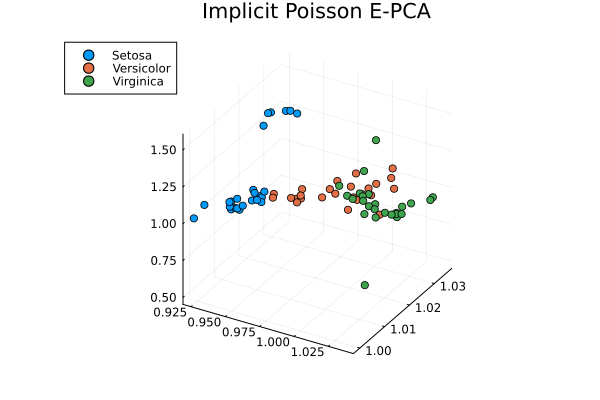

In [63]:
implicit_setosa_A = implicit_A[:, Xte_labels .== "setosa"]
implicit_versicolor_A = implicit_A[:, Xte_labels .== "versicolor"]
implicit_virginica_A = implicit_A[:, Xte_labels .== "virginica"]

p3 = scatter(implicit_setosa_A[1, :], implicit_setosa_A[2, :], implicit_setosa_A[3, :], marker=:circle, linewidth=0, label="Setosa")
scatter!(implicit_versicolor_A[1, :], implicit_versicolor_A[2, :], implicit_versicolor_A[3, :], marker=:circle, linewidth=0, label="Versicolor")
scatter!(implicit_virginica_A[1, :], implicit_virginica_A[2, :], implicit_virginica_A[3, :], marker=:circle, linewidth=0, label="Virginica")
plot!(p3, title="Implicit Poisson E-PCA")

In [64]:
implicit_Xr_poisson = decompress(Poisson, A')'

4×75 adjoint(::Matrix{Float64}) with eltype Float64:
 4.68611   4.78232   5.27016   …  6.66452  6.90462  6.66109  5.73524
 3.17492   3.13578   3.34481      2.76292  2.99581  3.02788  2.52038
 1.47002   1.63222   1.87615      6.71471  6.16294  5.2734   5.28213
 0.286065  0.334989  0.395878     2.60558  2.26161  1.78959  1.93149